In [82]:
import pandas as pd
import numpy as np
import re

## Load in data saved from scraping notebook
    - At this point we have a csv with the text and other various information from each video lecture.
    - The data still isn't labeled

In [181]:
lectures = pd.read_csv('all_lectures.csv')

In [182]:
lectures.drop([26],axis=0, inplace=True)
lectures.shape

(867, 7)

In [183]:
lectures.isnull().sum()

lecture_title     0
lecture_text      0
title             7
description      24
channelid         7
playlist_id       7
vidid             0
dtype: int64

In [184]:
#correct description for harvard CS50 lectures
lectures['description'] = np.where(pd.isnull(lectures.description) == True,'HAR_CS50',lectures.description)

In [185]:
lectures.isnull().sum()

lecture_title    0
lecture_text     0
title            7
description      0
channelid        7
playlist_id      7
vidid            0
dtype: int64

In [186]:
#These are the robotics lectures that i had to drop because there were only 7
lectures = lectures.dropna()

## add labels to data
    - we are going to use our list of playlist Ids and match them with their subject, then create a new target column based of playlist id

In [190]:
#load playlist csv
playlist_ids = pd.read_csv('playlists_math.csv')
playlist_ids.iloc[16].PlaylistID = 'PLUl4u3cNGP61hsJNdULdudlRL493b-XZf'

In [191]:
#we need some consolidation in terms of target subjects 
#we will create a dictionary with the playlist as a key and the subject as the value
subject_keys = playlist_ids.PlaylistID
subject_values = ['Probability','Statistics','CS','Algorithms','AI','Calculus','Calculus','Linear Algebra','Diff. Eq.',
                  'Linear Algebra','CS','Probability','CS','Algorithms','Math for Eng.','Statistics',
                  'Data Structures','Probability','NLP','CS','Statistics','Algebraic Geometry','Calculus','Calculus',
                  'Calculus','AI','Various','Calculus','Data Structures','Diff. Eq.','Math for Eng.','Linear Algebra',
                  'Linear Algebra','Diff. Eq.','Diff. Eq.','Diff. Eq.','Statistics','Linear Algebra']
subject_lookup = {i:j for i,j in zip(subject_keys,subject_values)}

In [192]:
#function to label a subject for a given videos PL id
subject_re = re.compile('(%s)' % '|'.join(subject_lookup.keys()))
def label_subjects(s, subject_lookup=subject_lookup):
    def replace(match):
        return subject_lookup[match.group(0)]
    return subject_re.sub(replace, s)

In [193]:
lectures['Subject'] = [ label_subjects(str(i)) for i in lectures.playlist_id]

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

In [195]:
subject_counts = lectures.Subject.value_counts().reset_index()

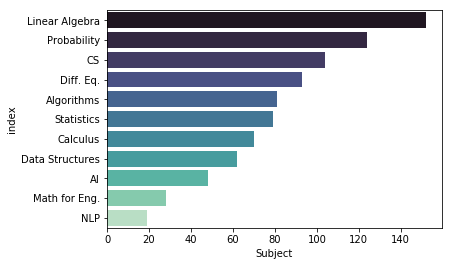

In [196]:
sns.barplot(x='Subject', y='index', data=subject_counts, palette='mako')

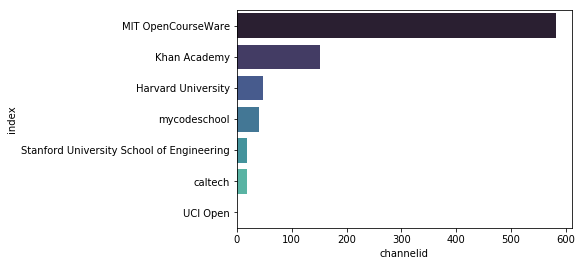

In [197]:
chan_cnt = lectures.channelid.value_counts().reset_index()
sns.barplot(x='channelid',y='index',data=chan_cnt, palette='mako')

## Cleaning, tokenizing the text
    - The text is pretty messy
    - we need to clean it up a bit.
    we do a clean up for the doc2vec model and another for the tfidf model

In [198]:
lectures.lecture_text[0][:295]

'The following content is\nprovided under a Creative Commons license. Your support will help\nMIT OpenCourseWare continue to offer high quality\neducational resources for free. To make a donation, or to\nview additional materials from hundreds of MIT courses,\nvisit MIT OpenCourseWare at ocw.mit.edu.'

This intro is tricky as the '\n's are not always in the same spot, so we can't use regex. My preference is to remove the first 300 characters of each lecture. Not all of the lectures start with a long intro like the MIT lectures, however this approach should not affect the integry of any one lecture's content.

In [199]:
#dictionary to tokenize punctuation
punt_dict = {'.':'||Period||',
            ',':'||Comma||',
            '"': '||Quotation_Mark||',
            ';':'||Semicolon||',
            '!':'||Exclamation_Mark||',
            '?':'||Question_Mark||',
            '(':'||Left_Para||',
            ')':'||Right_Para||',
            '-':'||Dash||',
            '\n':'||Return||'}

#dictionary of contractions
-

In [200]:
#for the doc2vec model, we wont remove the stop words

def make_d2v_data(lectures):
    clean_lectures = []
    #iterate over the text by lecture
    for lecture in lectures:
        #skip intro
        lecture = lecture[295:]
        #tokenize punctuation
        for key, token in punt_dict.items():
            lecture = lecture.replace(key, ' {} '.format(token))
        #expand contractions
        for key, expan in contract_dict.items():
            lecture = lecture.replace(key, ' {} '.format(expan))
        #append clean lecture to list of lectures
        clean_lectures.append(lecture)        
    return clean_lectures
        

In [201]:
lectures['d2v_text'] = make_d2v_data(lectures.lecture_text)

In [180]:
d2v_csv = lectures[['Subject','title','d2v_text']].copy()
d2v_csv.to_csv('all_lecture_text.csv', index=False)

In [203]:
d2v_csv.head()

,Subject,title,d2v_text
0,Calculus,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",PROFESSOR: So ||Comma|| ||Return|| Professor...
1,Probability,S01.0 Mathematical Background Overview,concepts ||Period|| I should say that ||Retur...
2,CS,8. Object Oriented Programming,FESSOR: All right everyone ||Period|| Let's g...
3,Algorithms,Recitation 9b: DNA Sequence Matching,OFESSOR: The things we ||Return|| can talk abo...
4,Algorithms,R10. Quiz 1 Review,FESSOR: All right ||Period|| So I brought a f...
